In [139]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted


In [140]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    data['disease'] = data.num.apply(lambda x: min(x,1))
    
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        
    data = data.drop('num', axis=1)
    data = data.dropna()

    X = data.drop('disease', axis=1)
    y = data['disease']
    
    return X.values, y.values

In [141]:
X, y = load_data('data/cleveland.csv')

In [142]:
class kNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.X_ = X
        self.y_ = y
        self.classes_ = np.unique(y)
        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return np.array([self._predict(x) for x in X])

    def _predict(self, x):
        distances = [np.sqrt(np.sum((x - x_train) ** 2)) for x_train in self.X_]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_[i] for i in k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]
    
    def get_params(self, deep=True):
        return {"k": self.k}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [143]:
def cross_validate(X, y, model, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    precisions = []
    recalls = []
    f1_scores = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Print precision, recall, and f1 score for each fold
        print("Precision:", precision_score(y_test, predictions), "Recall:", recall_score(y_test, predictions), "F1:", f1_score(y_test, predictions))
        precisions.append(precision_score(y_test, predictions, zero_division=0))
        recalls.append(recall_score(y_test, predictions, zero_division=0))
        f1_scores.append(f1_score(y_test, predictions, zero_division=0))
    
    return {
        'precision': (np.mean(precisions), np.std(precisions)),
        'recall': (np.mean(recalls), np.std(recalls)),
        'f1': (np.mean(f1_scores), np.std(f1_scores))
    }

In [144]:
knn = kNN(k=3)
results = cross_validate(X, y, knn)
print(f"\nMean Results for kNN:")
print(f"Precision: {results['precision'][0]:.3f} (+/- {results['precision'][1]:.3f})")
print(f"Recall: {results['recall'][0]:.3f} (+/- {results['recall'][1]:.3f})")
print(f"F1 Score: {results['f1'][0]:.3f} (+/- {results['f1'][1]:.3f})")

Precision: 0.5333333333333333 Recall: 0.7272727272727273 F1: 0.6153846153846154
Precision: 0.6666666666666666 Recall: 0.6153846153846154 F1: 0.64
Precision: 0.7857142857142857 Recall: 0.6470588235294118 F1: 0.7096774193548387
Precision: 0.8 Recall: 0.6666666666666666 F1: 0.7272727272727273
Precision: 0.6875 Recall: 0.55 F1: 0.6111111111111112
Precision: 0.625 Recall: 0.38461538461538464 F1: 0.47619047619047616
Precision: 0.47368421052631576 Recall: 0.75 F1: 0.5806451612903226
Precision: 0.6363636363636364 Recall: 0.5384615384615384 F1: 0.5833333333333334
Precision: 0.5 Recall: 0.5454545454545454 F1: 0.5217391304347826
Precision: 0.3076923076923077 Recall: 0.4444444444444444 F1: 0.36363636363636365

Mean Results for kNN:
Precision: 0.602 (+/- 0.143)
Recall: 0.587 (+/- 0.111)
F1 Score: 0.583 (+/- 0.103)


In [145]:
def feature_importance(X, y):
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X, y)
    importances = dt.feature_importances_
    return pd.Series(importances).sort_values(ascending=False)

importance_results = feature_importance(X, y)

print(importance_results)

12    0.279725
2     0.151193
11    0.108062
7     0.083773
4     0.079608
9     0.076073
0     0.072169
3     0.050094
10    0.031960
1     0.028341
6     0.016259
8     0.012420
5     0.010323
dtype: float64


In [146]:
def elbow_method(X, y, k_range):
    k_scores = []
    for k in k_range:
        knn = kNN(k=k)
        scores = cross_val_score(knn, X, y, cv=5, scoring='f1')
        k_scores.append(np.mean(scores))
    
    return k_scores

def plot_elbow_curve(k_range, k_scores):
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, k_scores, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Average F1 Score')
    plt.title('Elbow Method For Optimal k')
    plt.show()

def find_elbow_point(k_range, k_scores):
    differences = np.diff(k_scores)
    elbow_index = np.argmin(np.abs(differences)) + 1
    
    return k_range[elbow_index]

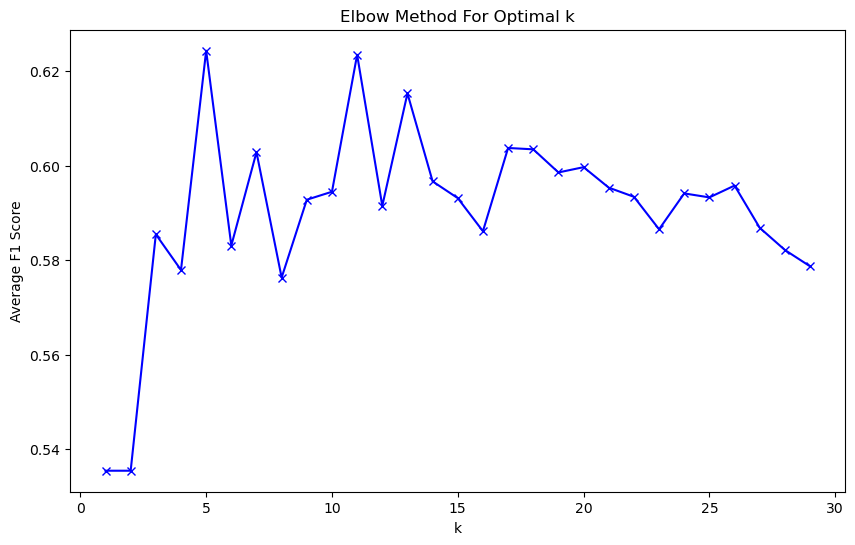

Optimal k value: 2


In [147]:
k_range = range(1, 30)
k_scores = elbow_method(X, y, k_range)
plot_elbow_curve(k_range, k_scores)
optimal_k = find_elbow_point(k_range, k_scores)
print(f"Optimal k value: {optimal_k}")